# DESI Spectra

This notebook shows a simple example of reading and plotting DESI spectra.

For a more complete tutorial based on Early Data Release (EDR) data, see https://github.com/desihub/tutorials/blob/main/getting_started/intro_to_DESI_EDR_files.ipynb

In [37]:
# Python and external package imports
import os
import numpy as np

import fitsio
from astropy.table import Table
from astropy.io import fits
import matplotlib.pyplot as plt

from astropy.convolution import convolve, Gaussian1DKernel

In [2]:
# DESI-specific imports
from desispec.io import read_spectra
from desispec.coaddition import coadd, coadd_cameras
from desispec.io import findfile

In [3]:
specprod = 'loa'    # production name for the final Year 3 (Y3) production
desi_root = os.environ['DESI_ROOT']
desi_root_ro = os.environ['DESI_ROOT_READONLY']
specprod_dir = f'{desi_root_ro}/spectro/redux/{specprod}'
print(specprod_dir)

/dvs_ro/cfs/cdirs/desi/spectro/redux/loa


Since all the directory manipulation to find specific files is a pain,
we'll use `desispec.io.findfile`, which also requires us to set `$SPECPROD`.

In [4]:
os.environ['SPECPROD'] = specprod

tileid = 2196
lastnight = 20210514
coadd_file = findfile('coadd', tile=tileid, night=lastnight, spectrograph=0, readonly=True)
redrock_file = findfile('redrock', tile=tileid, night=lastnight, spectrograph=0, readonly=True)

print(coadd_file)
print(redrock_file)

/dvs_ro/cfs/cdirs/desi/spectro/redux/loa/tiles/cumulative/2196/20210514/coadd-0-2196-thru20210514.fits
/dvs_ro/cfs/cdirs/desi/spectro/redux/loa/tiles/cumulative/2196/20210514/redrock-0-2196-thru20210514.fits


## Read a redrock file and pick good QSO fits

In [11]:
rr = Table.read(redrock_file, 'REDSHIFTS')

In [13]:
isQSO = (rr['SPECTYPE'] == 'QSO') & (rr['ZWARN']==0) & (rr['DELTACHI2']>25)
qso_indices = np.where(isQSO)[0]
print(qso_indices)

[  2   5  16  24  27  30  34  37  55  65  70  85  87  92  94  95  96 102
 119 120 123 132 138 140 142 145 146 147 151 156 161 175 178 184 194 225
 226 230 236 244 246 249 250 258 262 264 269 270 283 284 298 302 304 308
 310 333 335 341 344 345 346 352 354 355 362 366 379 383 397 403 412 413
 417 425 434 435 437 441 449 460 462 463 467 493 497]


## Spectra files format

In [42]:
fp = fits.open(coadd_file)
fp.info()

Filename: /dvs_ro/cfs/cdirs/desi/spectro/redux/loa/tiles/cumulative/2196/20210514/coadd-0-2196-thru20210514.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      61   ()      
  1  FIBERMAP      1 BinTableHDU    315   500R x 82C   [K, I, J, K, J, J, D, D, 22A, E, E, E, E, K, B, 3A, E, E, J, D, J, I, 8A, J, J, 4A, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, I, E, E, E, E, K, 2A, E, E, E, E, 1A, K, K, K, K, K, K, D, D, J, I, E, I, I, E, E, E, E, E, E, E, D, E, D, E, D, D, D]   
  2  EXP_FIBERMAP    1 BinTableHDU    176   1500R x 29C   [K, J, D, J, J, D, J, D, I, J, K, J, J, E, E, E, D, D, K, D, D, D, D, D, D, D, L, L, L]   
  3  B_WAVELENGTH    1 ImageHDU        10   (2751,)   float64   
  4  B_FLUX        1 ImageHDU        11   (2751, 500)   float32   
  5  B_IVAR        1 ImageHDU        11   (2751, 500)   float32   
  6  B_MASK        1 ImageHDU        10   (2751, 500)   int32   
  7  B_RESOLUTION    1 ImageHDU        11   (2751

Spectra files have the following HDUs (Header Data Units):

  * FIBERMAP: information about the targets like their fluxes and location on the sky
  * EXP_FIBERMAP: information about the targets that is specific to individual exposures, not coadds
  * X_WAVELENGTH: wavelength array covered by camera X=B,R,Z
  * X_FLUX: flux[spectra,wavelength] for camera X=B,R,Z
  * X_IVAR: inverse variance (1/error^2) for flux
  * X_MASK: mask of bad pixels for flux, 0=good
  * X_RESOLUTION: models intrument resolution, beyond the scope of this tutorial
  * SCORES: additional quality information about the spectra

## Reading DESI spectra with `desispec.io.read_spectra`

Although you could read these HDUs individually to contruct spectra, it can be useful
to use `desispec.io.read_spectra` to get a `Spectra` object that bundles all of this together.

In [6]:
spectra = read_spectra(coadd_file)

INFO:spectra.py:391:read_spectra: iotime 1.537 sec to read coadd-0-2196-thru20210514.fits at 2024-12-13T10:57:17.012130


By default, DESI spectra keep the cameras b,r,z separate.
This is admittedly somewhat of a pain, but it doesn't lose information by coadding
across the camera boundaries.  As a result, the wavelength and flux values are kept per-camera.

The wavelength arrays are 1D, shared by all spectra, and the `flux` arrays are 2D spectra x wavelength

In [7]:
spectra.wave.keys()

dict_keys(['b', 'r', 'z'])

In [8]:
spectra.flux.keys()

dict_keys(['b', 'r', 'z'])

In [9]:
spectra.wave['b'].shape

(2751,)

In [10]:
spectra.flux['b'].shape

(500, 2751)

Text(0, 0.5, 'Flux')

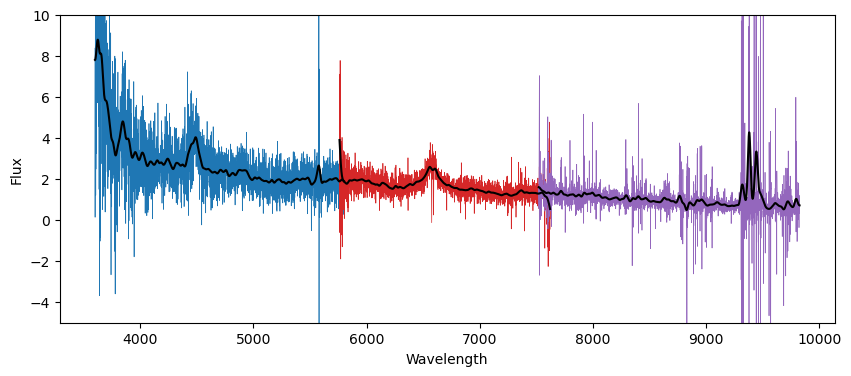

In [36]:
kernel = Gaussian1DKernel(15)

i = qso_indices[2]
plt.figure(figsize=(10,4))
plt.plot(spectra.wave['b'], spectra.flux['b'][i], lw=0.5, color='C0')
plt.plot(spectra.wave['r'], spectra.flux['r'][i], lw=0.5, color='C3')
plt.plot(spectra.wave['z'], spectra.flux['z'][i], lw=0.5, color='C4')

# plot smoothed spectra for visualization
plt.plot(spectra.wave['b'], convolve(spectra.flux['b'][i], kernel, boundary='extend'), color='k')
plt.plot(spectra.wave['r'], convolve(spectra.flux['r'][i], kernel, boundary='extend'), color='k')
plt.plot(spectra.wave['z'], convolve(spectra.flux['z'][i], kernel, boundary='extend'), color='k')

plt.ylim(-5, 10)
plt.xlabel('Wavelength')
plt.ylabel('Flux')

## More info

* https://github.com/desihub/tutorials/blob/main/getting_started/intro_to_DESI_EDR_files.ipynb
* https://github.com/desihub/tutorials/blob/main/getting_started/SubselectSpectra.ipynb
